# TRAINING JUPYTER

In [1]:
# Imports et variables setting

# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  CST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Parameter setting and preprocessing

In [4]:

np.random.seed(0)
D2 = []
D2 = [DictPrepross(['o3','pl','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(False)] )]
D = [Load_FLX_dict()]
##### Kernels

Klist = []
fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=512, train=True, preprocess_x=D)

#D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['t'].fit(fit_genator[0][0][:,:,-2])

Klist =[]
Klist = [ProdKernel([('o3', 'pl')])]

# V
V = [VarSuppression(['ts', 'rl', 'ri','pl', 'o3'])]

##### Full Preprocessing :
FP = D + D2 + Klist + V 
##### b_size
batch_size= 64

train_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP)
validation_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=False, preprocess_x=FP, custom_b_p_e = 50)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

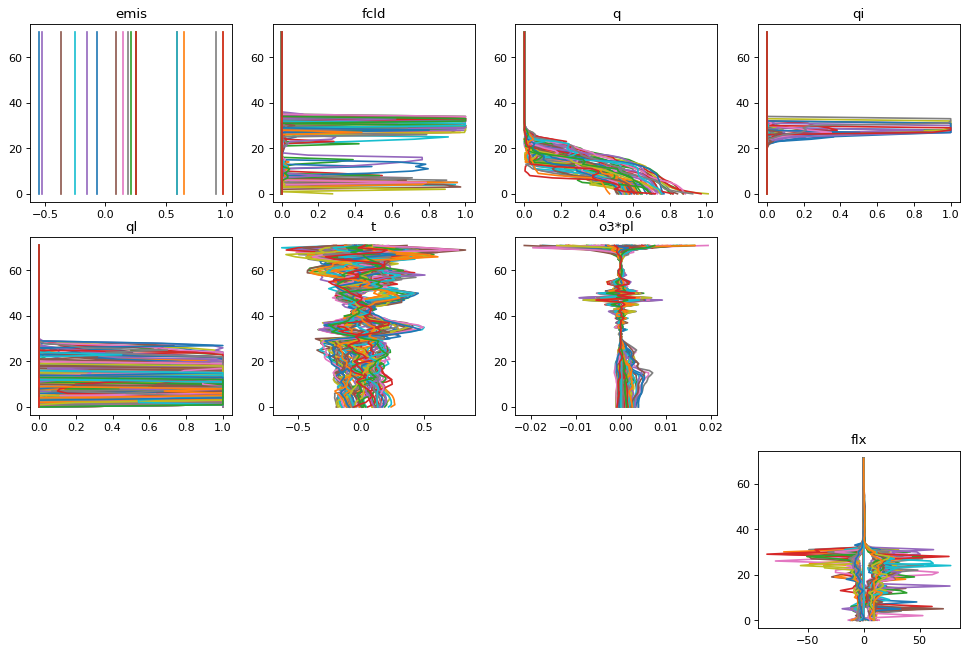

In [5]:
from utils import Plot_Batch

x,y = train_generator[0]
Plot_Batch(x,y,header_x, swap=True)

## II) ARCHITECTURES

### BD or BD+Unet

In [2]:
from architectures import Unet, LossHistory, Generate_Log, Bidir_Casual_Conv
from architectures import total_loss, flxd_loss, flxu_loss, dfdts_loss

import keras.backend as K
from keras import optimizers
import datetime

ups=5
pooling=22
units = [300, 100,72*3]

prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")


### ANALYSIS :

### Load a model

In [4]:
from keras import Input
in_channel=11
inter_channel=50
o_channel=3
ups=5
pooling=3

"TrainedModels/20190521212840U.pickle"
list_of_filters_bdc=[[64, 32], [32, 20], [50]]
list_of_kernel_bdc=[[10, 5], [10, 5], [5]]
list_of_filters_unet=[[50, 75, 100], [270], [50, 75, 100]]
list_of_kernel_unet=[[10, 5, 3], [], [10, 5, 3]]

"TrainedModels/20190521201850U.pickle"
list_of_filters_bdc=[[128, 64], [64, 16], [50, 50]]
list_of_kernel_bdc=[[10, 5], [10, 5], [10, 5]]
list_of_filters_unet=[[30, 75, 100], [270], [100, 40, 25]]
list_of_kernel_unet=[[10, 5, 3], [], [5, 8, 12]]

M_bd_cas = Bidir_Casual_Conv(list_of_kernel_bdc, list_of_filters_bdc, ups, pooling, in_channel, o_channel=inter_channel, lev=CST.lev(CST))

# unet


M_unet = Unet(list_of_kernel_unet, list_of_filters_unet, [], Div=3, lev=72, in_channel=inter_channel, o_channel=o_channel)

N_input = Input( shape=(72, in_channel))
Inter_m = M_bd_cas(N_input)
N_output = M_unet(Inter_m)
M =keras.Model( N_input, N_output)

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:150: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(3, padding="same", name="AVG_p", strides=5)`
  I_avg = AveragePooling1D(pooling, padding='same', stride=ups, name='AVG_p')(I_cp)
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:193: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(9, padding="same", name="AVG_1", strides=2)`
  Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', stride=2, name=Name('AVG', i+1))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:193: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(4, padding="same", name="AVG_2", strides=2)`
  Poolings_l.append(AveragePooling1D(list_of_kernels_s[0][i]-1, padding='same', stride=2, name=Name('AVG', i+1))(Convs_l1[-1]))
/home/victor/Documents/Stage/FLXm

In [5]:
import pickle
a = pickle.load( open( "TrainedModels/20190521201850U.pickle", "rb" ) )

for i,l in enumerate(M.layers[1].layers):
#    if(len(l.get_weights())>0):
#        print(np.max(abs(a[1][i][0] - l.get_weights()[0])))
    l.set_weights(a[1][i])
for i,l in enumerate(M.layers[2].layers):
#    if(len(l.get_weights())>0):
#        print(np.max(abs(a[0][i][0] - l.get_weights()[0])))
    l.set_weights(a[0][i])

In [6]:
from utils import Plot_triple_diff_separated, F_and_plots

j=np.random.randint(batch_size)
i=np.random.randint(len(validation_generator))

x,y = validation_generator[i]
y0 = M.predict(x)
F=F_and_plots(shape=(3,3),figsize=(15,10))
print(i,j)
Plot_triple_diff_separated(F, y,y0, header_y, sep=35, j=j)

InternalError: cudnn PoolForward launch failed
	 [[Node: model_1/AVG_p/AvgPool = AvgPool[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 3, 1], padding="SAME", strides=[1, 1, 5, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_1/AVG_p/AvgPool-0-TransposeNHWCToNCHW-LayoutOptimizer)]]
	 [[Node: model_2/conv1d_1/convolution/Squeeze/_207 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_853_model_2/conv1d_1/convolution/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [4]:
from contextlib import redirect_stdout
with open(os.path.join(log_folder, prefix), 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        modelbd2.summary()
        modelbd.summary()
        for loss in FP:
            print(loss)
        print(history.history)

NameError: name 'seed' is not defined

In [7]:
x.shape

(64, 72, 11)

### VISUALISATION

In [145]:
def Compare(y,y0, i=0):
    f=plt.figure( figsize=(15,8), dpi=80)
    ax= f.add_subplot(1,2,1)
    ax.plot(np.flip(y0[i]), np.arange(len(y0[i]))) 
    ax.plot(np.flip(y[i]), np.arange(len(y0[i]))) 
    ax.legend(["y pred", 'y truth'])
#    ax.title("Diff")
    y_cumsum = np.cumsum(y[i])
    y0_cumsum = np.cumsum(y0[i])
    ax= f.add_subplot(1,2,2)
    ax.plot(np.flip(y0_cumsum), np.arange(len(y0[i])))        
    ax.plot(np.flip(y_cumsum), np.arange(len(y0[i])))        
    ax.legend(["y pred", 'y truth'])
#    ax.title("Cumulative")
    plt.show()

def eliminate_all_but_1(m,x):
    O = []
    for i in range(11):
        x0= x.copy()
        x0*=0
        x0[:,:,i]=x[:,:,i]
        O.append(m.predict(x0))
    O.append(x.copy)
    return(np.array(O))

def eliminate_one(m,x):
    O = []
    for i in range(11):
        x0= x.copy()
        x0[:,:,i]*=0
        O.append(m.predict(x0))
    O.append(m.predict(x0)*0)
    return(np.array(O))


def Plot_Predictions(O, y, header):
    f=plt.figure( figsize=(15,10), dpi=80)
    for i,y0 in enumerate(O):
        ax= f.add_subplot(3,4,i+1)
        ax.set_title(header[i])
        for b in range(y0.shape[0]):
            ax.plot(np.flip(y0[b]), np.arange(len(y0[b])))
    ax= f.add_subplot(3,4,12)
    ax.set_title('flx')
    for b in range(y0.shape[0]):
        ax.plot(np.flip(y[b]), np.arange(len(y[b])))

def Normal2(x,header):
    O1 = []#['fcld', 'q','qi','ql','rl','ri']
    N = [ 'pl']
    STD = []
    STD2 = []
    for i, h in enumerate(header):
        if h in O1:
            x[:,:,i] = np.max(x[:,:,i], axis=1).reshape(x.shape[0],1)
        if h in N:
            #print(h, np.mean(x[:,:,i], axis=0)[32])
            x[:,:,i] -= np.mean(x[:,:,i], axis=0)
        if h in STD:
            x[:,:,i] /= (x[:,-1,i]+0.000000001).reshape(-1,1)         
        if h in STD2:
            x[:,:,i] /= (x[:,0,i]+0.000000001).reshape(-1,1)         
    return(x)


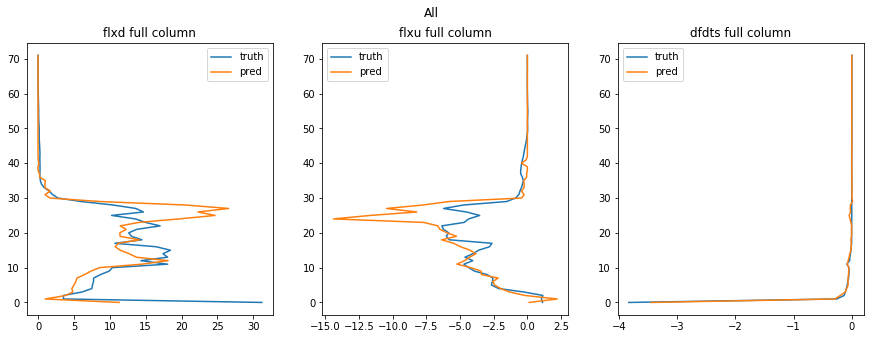

<Figure size 1080x576 with 0 Axes>

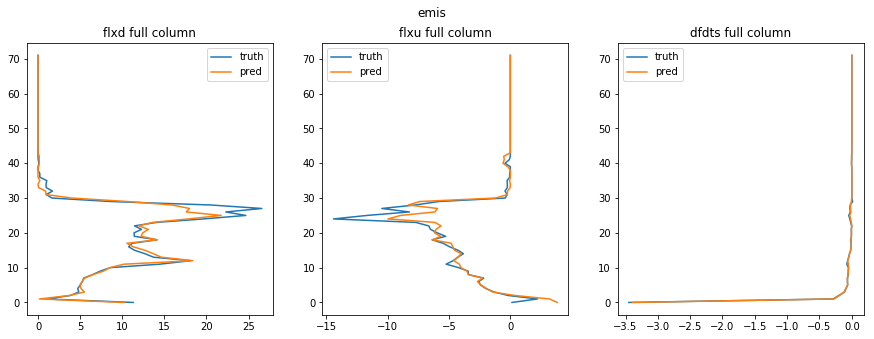

<Figure size 1080x576 with 0 Axes>

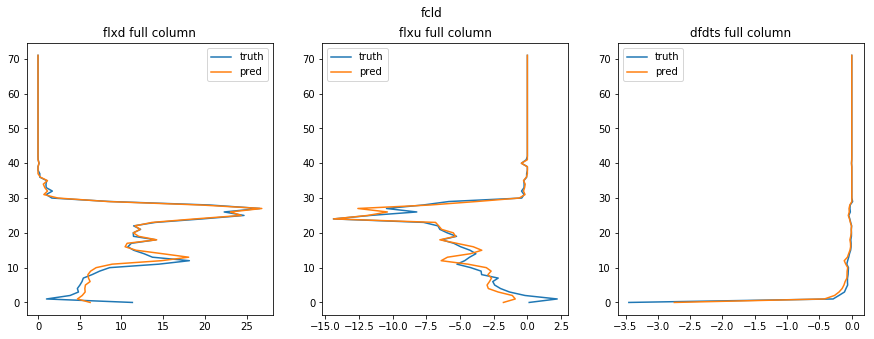

<Figure size 1080x576 with 0 Axes>

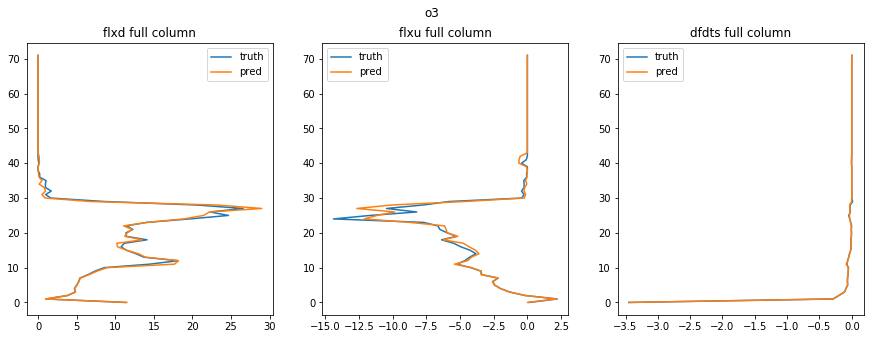

<Figure size 1080x576 with 0 Axes>

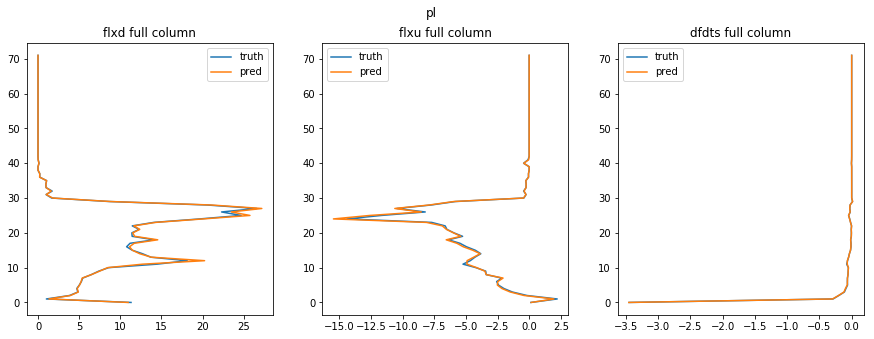

<Figure size 1080x576 with 0 Axes>

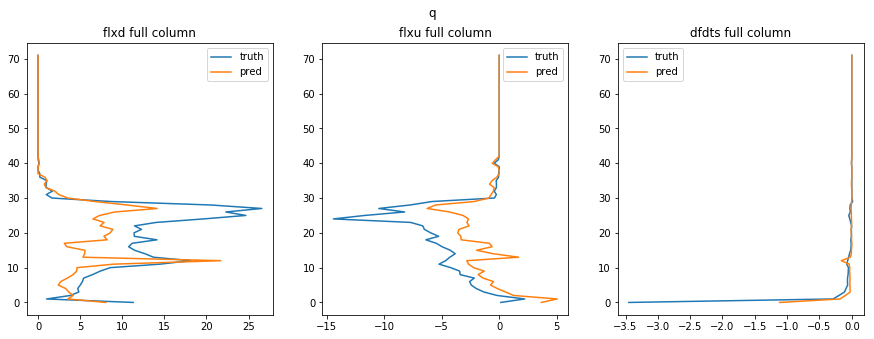

<Figure size 1080x576 with 0 Axes>

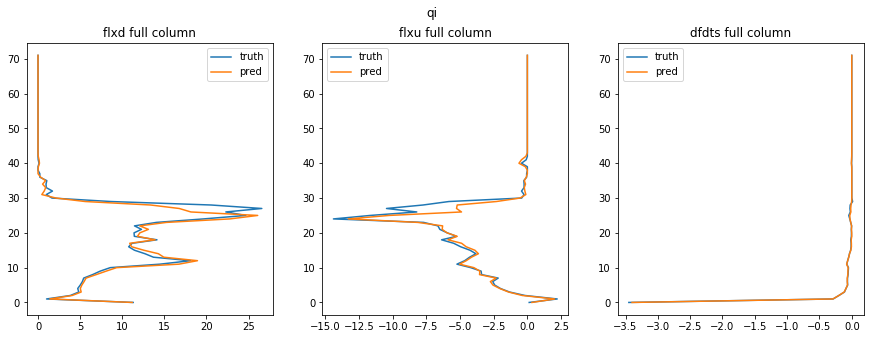

<Figure size 1080x576 with 0 Axes>

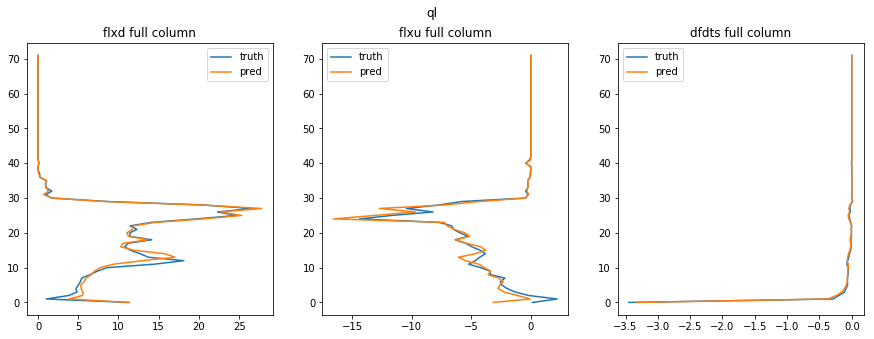

<Figure size 1080x576 with 0 Axes>

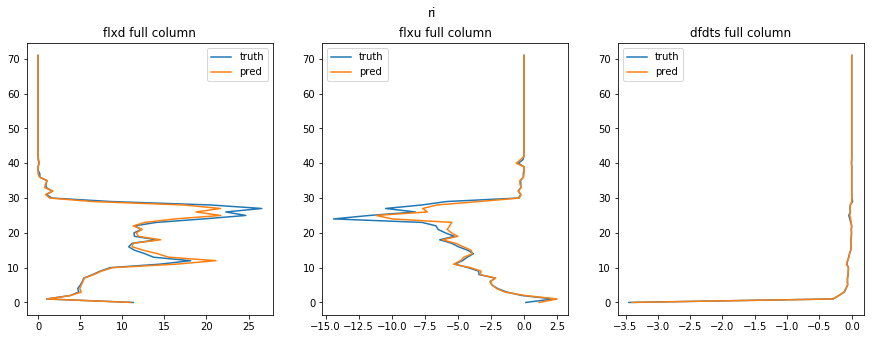

<Figure size 1080x576 with 0 Axes>

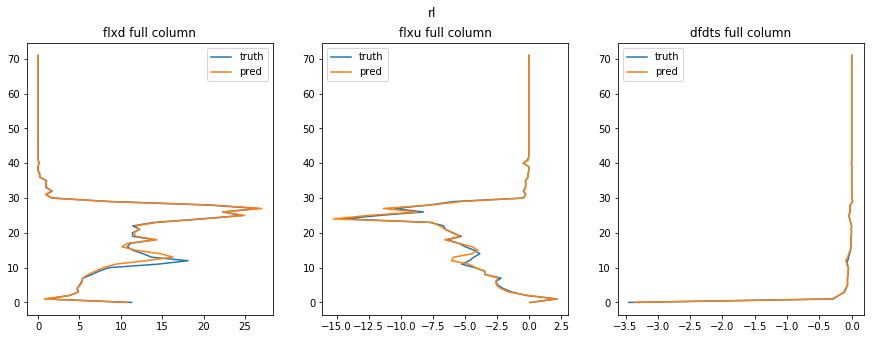

<Figure size 1080x576 with 0 Axes>

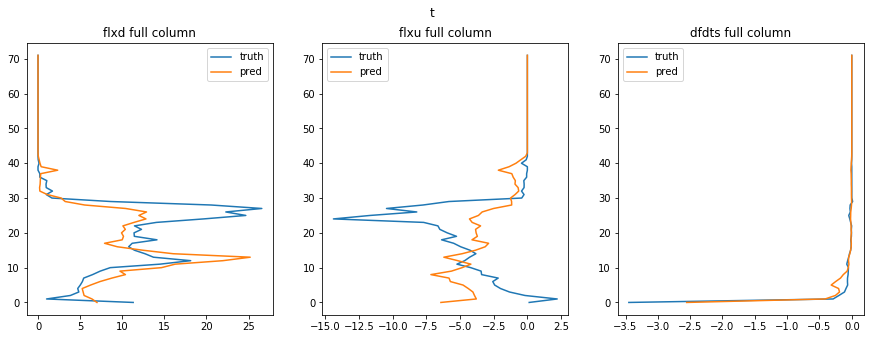

<Figure size 1080x576 with 0 Axes>

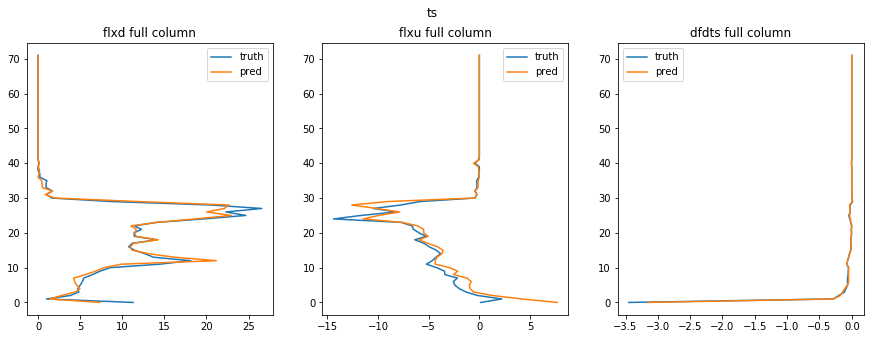

<Figure size 1080x576 with 0 Axes>

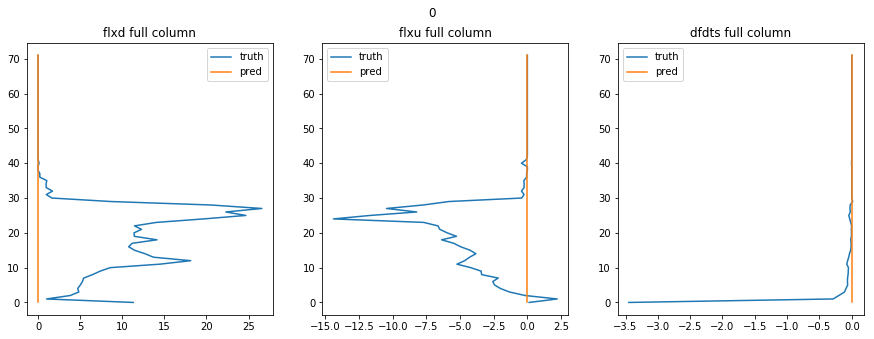

<Figure size 1080x576 with 0 Axes>

In [146]:
x,y = validation_generator[ validation_generator.ids_to_index((0,4,np.random.randint(1000))) ]
O1 = eliminate_one(M,x)
O0 = eliminate_all_but_1(M,x)

y_pred = []
y0 = M.predict(x)
F = F_and_plots((1,3), figsize=(15,5))
F.f.suptitle("All")
j=60
Plot_triple_diff_separated(F  , y, y0, header_y, sep=0, j=j)

for i in range(12):
#    y_pred.append(model_bd_avg_2.predict(X[i]))
    F = F_and_plots((1,3), figsize=(15,5))
    if i==11:
        F.f.suptitle('0')
    else:
        F.f.suptitle(header_x[i])        
    Plot_triple_diff_separated(F  , y0, O1[i], header_y, sep=0, j=j)

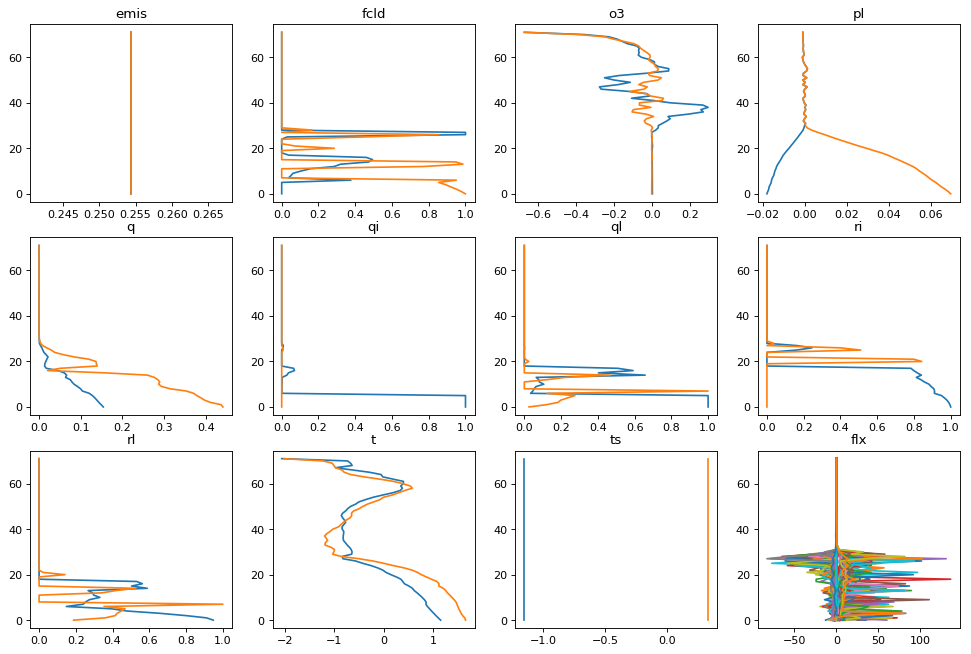

In [138]:
Plot_Batch(x.swapaxes(1,2)[[0,60]],y, header_x)

In [121]:
def RMSE(model, x,y_true):
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean(K.get_value(flxd_loss(y_true, y_pred))))
    return(rmse)

In [125]:
RMSE(M,x, y)

4.056657

### SECOND ARCHITECTURE :
Not tested yet

# III) TRACKS 

### MODEL 2 :

- FCNN
- (with AE)

##### MODEL 2 : FCM-Final FC

##### MODEL 2 : U-net :
- use regular U-net so all layers affect each other and more stability

### MODEL 3 : Bidir-LSTM 
> Possible alternatives

- use two LSTM to show both impact of superior and inferior layer
- use attention model over it
- use w embeddings before

> TD

- Read git trez
- Read article of Hedge fun